OpenMC's general tally system accommodates a wide range of tally *filters*. While most filters are meant to identify regions of phase space that contribute to a tally, there are a special set of functional expansion filters that will multiply the tally by a set of orthogonal functions, e.g. Legendre polynomials, so that continuous functions of space or angle can be reconstructed from the tallied moments.

In this example, we will determine the spatial dependence of the flux along the $z$ axis by making a Legendre polynomial expansion. Let us represent the flux along the z axis, $\phi(z)$, by the function

$$ \phi(z') = \sum\limits_{n=0}^N a_n P_n(z') $$

where $z'$ is the position normalized to the range [-1, 1]. Since $P_n(z')$ are known functions, our only task is to determine the expansion coefficients, $a_n$. By the orthogonality properties of the Legendre polynomials, one can deduce that the coefficients, $a_n$, are given by

$$ a_n = \frac{2n + 1}{2} \int_{-1}^1 dz' P_n(z') \phi(z').$$

Thus, the problem reduces to finding the integral of the flux times each Legendre polynomial -- a problem which can be solved by using a Monte Carlo tally. By using a Legendre polynomial filter, we obtain stochastic estimates of these integrals for each polynomial order.

In [1]:
%matplotlib inline
import openmc
import numpy as np
import matplotlib.pyplot as plt

To begin, let us first create a simple model. The model will be a slab of fuel material with reflective boundaries conditions in the x- and y-directions and vacuum boundaries in the z-direction. However, to make the distribution slightly more interesting, we'll put some B<sub>4</sub>C in the middle of the slab.

In [2]:
# Define fuel and B4C materials
fuel = openmc.Material()
fuel.add_element('U', 1.0, enrichment=4.5)
fuel.add_nuclide('O16', 2.0)
fuel.set_density('g/cm3', 10.0)

b4c = openmc.Material()
b4c.add_element('B', 4.0)
b4c.add_element('C', 1.0)
b4c.set_density('g/cm3', 2.5)

In [3]:
# Define surfaces used to construct regions
zmin, zmax = -10., 10.
box = openmc.model.get_rectangular_prism(10., 10., boundary_type='reflective')
bottom = openmc.ZPlane(z0=zmin, boundary_type='vacuum')
boron_lower = openmc.ZPlane(z0=-0.5)
boron_upper = openmc.ZPlane(z0=0.5)
top = openmc.ZPlane(z0=zmax, boundary_type='vacuum')

# Create three cells and add them to geometry
fuel1 = openmc.Cell(fill=fuel, region=box & +bottom & -boron_lower)
absorber = openmc.Cell(fill=b4c, region=box & +boron_lower & -boron_upper)
fuel2 = openmc.Cell(fill=fuel, region=box & +boron_upper & -top)
geom = openmc.Geometry([fuel1, absorber, fuel2])

For the starting source, we'll use a uniform distribution over the entire box geometry.

In [4]:
settings = openmc.Settings()
spatial_dist = openmc.stats.Box(*geom.bounding_box)
settings.source = openmc.Source(space=spatial_dist)
settings.batches = 210
settings.inactive = 10
settings.particles = 1000

Defining the tally is relatively straightforward. One simply needs to list 'flux' as a score and then add an expansion filter. For this case, we will want to use the `SpatialLegendreFilter` class which multiplies tally scores by Legendre polynomials evaluated on normalized spatial positions along an axis.

In [5]:
# Create a flux tally
flux_tally = openmc.Tally()
flux_tally.scores = ['flux']

# Create a Legendre polynomial expansion filter and add to tally
order = 8
expand_filter = openmc.SpatialLegendreFilter(order, 'z', zmin, zmax)
flux_tally.filters.append(expand_filter)

The last thing we need to do is create a `Tallies` collection and export the entire model, which we'll do using the `Model` convenience class.

In [6]:
tallies = openmc.Tallies([flux_tally])
model = openmc.model.Model(geometry=geom, settings=settings, tallies=tallies)

Running a simulation is now as simple as calling the `run()` method of `Model`.

In [7]:
model.run(output=False)

0.3016877031715249+/-0.0006126949350699303

Now that the run is finished, we need to load the results from the statepoint file.

In [8]:
with openmc.StatePoint('statepoint.210.h5') as sp:
    df = sp.tallies[flux_tally.id].get_pandas_dataframe()

We've used the `get_pandas_dataframe()` method that returns tally data as a Pandas dataframe. Let's see what the raw data looks like.

In [9]:
df

,spatiallegendre,nuclide,score,mean,std. dev.
0,P0,total,flux,36.434828,0.076755
1,P1,total,flux,0.021797,0.043545
2,P2,total,flux,-4.380892,0.025739
3,P3,total,flux,0.001448,0.020740
4,P4,total,flux,-0.295439,0.014215
5,P5,total,flux,0.003514,0.012017
6,P6,total,flux,0.105213,0.010103
7,P7,total,flux,0.002595,0.009265
8,P8,total,flux,-0.096197,0.007513


Since the expansion coefficients are given as

$$ a_n = \frac{2n + 1}{2} \int_{-1}^1 dz' P_n(z') \phi(z')$$

we just need to multiply the Legendre moments by $(2n + 1)/2$.

In [10]:
n = np.arange(order + 1)
a_n = (2*n + 1)/2 * df['mean']

To plot the flux distribution, we can use the `numpy.polynomial.Legendre` class which represents a truncated Legendre polynomial series. Since we really want to plot $\phi(z)$ and not $\phi(z')$ we first need to perform a change of variables. Since

$$ \lvert \phi(z) dz \rvert = \lvert \phi(z') dz' \rvert $$

and, for this case, $z = 10z'$, it follows that

$$ \phi(z) = \frac{\phi(z')}{10} = \sum_{n=0}^N \frac{a_n}{10} P_n(z'). $$

In [11]:
phi = np.polynomial.Legendre(a_n/10, domain=(zmin, zmax))

Let's plot it and see how our flux looks!

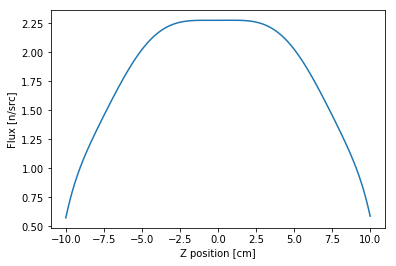

In [12]:
z = np.linspace(zmin, zmax, 1000)
plt.plot(z, phi(z))
plt.xlabel('Z position [cm]')
plt.ylabel('Flux [n/src]')

As you might expect, we get a rough cosine shape but with a flux depression in the middle due to the boron slab that we introduced. To get a more accurate distribution, we'd likely need to use a higher order expansion.

One more thing we can do is confirm that integrating the distribution gives us the same value as the first moment (since $P_0(z') = 1$). This can easily be done by numerically integrating using the trapezoidal rule:

In [13]:
np.trapz(phi(z), z)

36.434786672754925

In addition to being able to tally Legendre moments, there are also functional expansion filters available for spherical harmonics (`SphericalHarmonicsFilter`) and Zernike polynomials over a unit disk (`ZernikeFilter`). A separate `LegendreFilter` class can also be used for determining Legendre scattering moments (i.e., an expansion of the scattering cosine, $\mu$).